In [1]:
from lib.text_exploration.doc_explorer import DocExplorer, LemmaTokenizer, remove_non_alphabetic
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from nltk.corpus import reuters
from matplotlib import pyplot as plt
%matplotlib inline  

In [2]:
selected_categories = ['housing', 'gas', 'tea', 'lumber', 'jobs', 'retail']
texts = []
for c in selected_categories:
    for file in reuters.fileids(c):
        texts.append(reuters.raw(file))


In [3]:
tf_vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer(), preprocessor=remove_non_alphabetic, max_df=0.5)
tf_idf_matrix = tf_vectorizer.fit_transform(texts).toarray()

tsne = TSNE(perplexity=20, early_exaggeration=30)
X_em = tsne.fit_transform(tf_idf_matrix)

dbscan = DBSCAN(eps=1, min_samples=4)
clusters = dbscan.fit_predict(tf_idf_matrix)


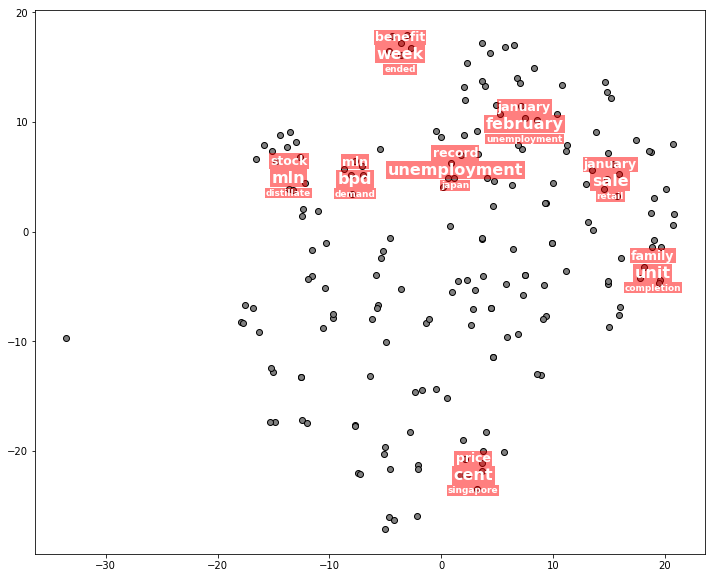

In [4]:
doc_explorer = DocExplorer()
doc_explorer.fit(texts, X_em=X_em, clusters=clusters)
doc_explorer.plot_static()

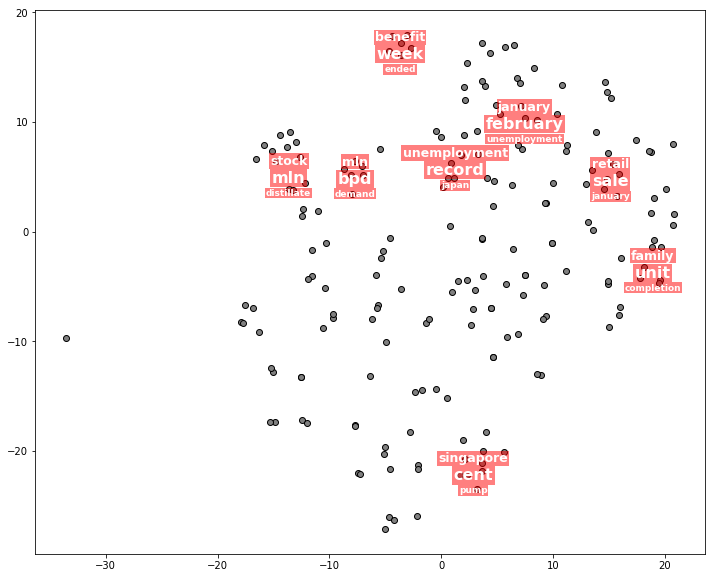

In [5]:
doc_explorer = DocExplorer(method='g2')
doc_explorer.fit(texts, X_em=X_em, clusters=clusters)
doc_explorer.plot_static()